In [1]:
import numpy as np
import pandas as pd

In [2]:
turb_data=pd.read_csv('../../turb_data.csv')
turb_data

,x_coord,y_coord,ref_wind_speed,wind_speed,turb_num,num_tot_turb,ID,IDnum
0,0.000000,0.0,4.359392,6,0,3,3_turbine_155th_simulation,0
1,2633.103635,-226.0,4.387136,6,1,3,3_turbine_155th_simulation,0
2,57.854836,-545.0,4.358929,6,2,3,3_turbine_155th_simulation,0
3,0.000000,0.0,4.355684,6,0,3,3_turbine_141th_simulation,1
4,1935.499403,264.0,4.383674,6,1,3,3_turbine_141th_simulation,1
...,...,...,...,...,...,...,...,...
3835,294.588246,-52.0,18.847122,20,1,3,3_turbine_65th_simulation,1278
3836,1773.331277,-295.0,19.222500,20,2,3,3_turbine_65th_simulation,1278
3837,0.000000,0.0,19.118147,20,0,3,3_turbine_71th_simulation,1279
3838,3106.576695,-431.0,19.286488,20,1,3,3_turbine_71th_simulation,1279


In [3]:
dataset=turb_data.drop(['ID','turb_num'], axis=1)

In [4]:
import os
os.chdir("../..")
import descriptor.three_desc_model_nn as desc
from descriptor.cutoffs import Polynomial
import matplotlib.pyplot as plt
import GPy
from IPython.display import display
symbol="Siemens"
turb = [symbol]
numsims=dataset["IDnum"].iloc[-1]+1

In [5]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.25])
    plt.xlabel('Epoch')
    plt.ylabel('Error [ref_wind_speed]')
    plt.legend()
    plt.grid(True)

In [6]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [7]:
Gs = desc.make_symmetry_functions(turbines=symbol, type='G2',
                                    etas=np.linspace(1,10,5),
                                    offsets=[2])
Gs += desc.make_symmetry_functions(turbines=symbol, type='G4',
                                     etas=np.linspace(1,10,5),
                                     gammas=[10])
Gs += desc.make_symmetry_functions(turbines=symbol, type='G6',
                                     etas=np.linspace(1,10,5),
                                     gammas=[0])

In [8]:
# Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":4.25387599, "offset": 1.0151402},
#                   {"type":"G4", "elements":"Siemens","eta":2.56450515, "gamma":8.04475192},
#                   {"type":"G6", "elements":"Siemens","eta":2.33043463, "gamma": 0.50753377}
#                  ]}

In [9]:
#Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":3.24310834, "offset": 1.9817547},
#                  {"type":"G4", "elements":"Siemens","eta":2.48579287, "gamma":12.39114317},
#                  {"type":"G6", "elements":"Siemens","eta":1.27537145, "gamma": 0.2110151}
#                 ]}

In [10]:
nl=desc.NeighborlistCalculator(cutoff=4001,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
finpr=desc.FingerprintCalculator(cutoff=4001,Gs=Gs,Rct=3000,delta_R=100,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
count=0
dataset_fp=np.empty(shape=(0, len(Gs)))
dataset_rws=np.empty(shape=(0, 1))
dataset_ws=np.empty(shape=(0, 1))
dataset_pos=np.empty(shape=(0, 2))
for i in range(numsims):
    numturb=dataset["num_tot_turb"].iloc[count]
    position = np.empty((numturb,2))
    ws = np.empty((numturb,1))
    fp = np.empty((numturb,3))
    rws = np.empty((numturb,1))
    for k in range(numturb):
        position[k,0]=dataset["x_coord"].iloc[count]
        position[k,1]=dataset["y_coord"].iloc[count]
        ws[k,0]=dataset["wind_speed"].iloc[count]
        rws[k,0]=dataset["ref_wind_speed"].iloc[count]
        count = count+ 1
    neigh=nl.calculate(turb*numturb,position)
    fingerprints=finpr.calculate(turb*numturb,position,neigh,symbol)
    fingerprints=np.array(fingerprints)
    dataset_fp=np.append(dataset_fp,fingerprints,axis=0)
    dataset_rws=np.append(dataset_rws,rws,axis=0)
    dataset_ws=np.append(dataset_ws,ws,axis=0)
    dataset_pos=np.append(dataset_pos,position,axis=0)
dataset=np.concatenate((dataset_fp, dataset_ws, dataset_rws),axis=1)
dataset = pd.DataFrame(dataset)#, columns = ['Fingerprint(G2)','Fingerprint(G4)','Fingerprint(G6)','Ref_Wind_Speed','Wind_Speed'])

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()
all_features = dataset.copy()

train_labels = train_features.iloc[:,-1]
test_labels = test_features.iloc[:,-1]
all_labels = all_features.iloc[:,-1]

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

2023-07-26 13:25:52.572365: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 17)               35        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                1152      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                        

In [13]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=10000)

CPU times: user 18min 8s, sys: 4min 7s, total: 22min 16s
Wall time: 11min 31s


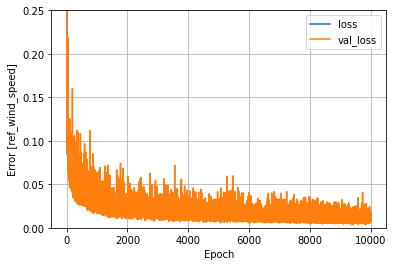

In [14]:
plot_loss(history)

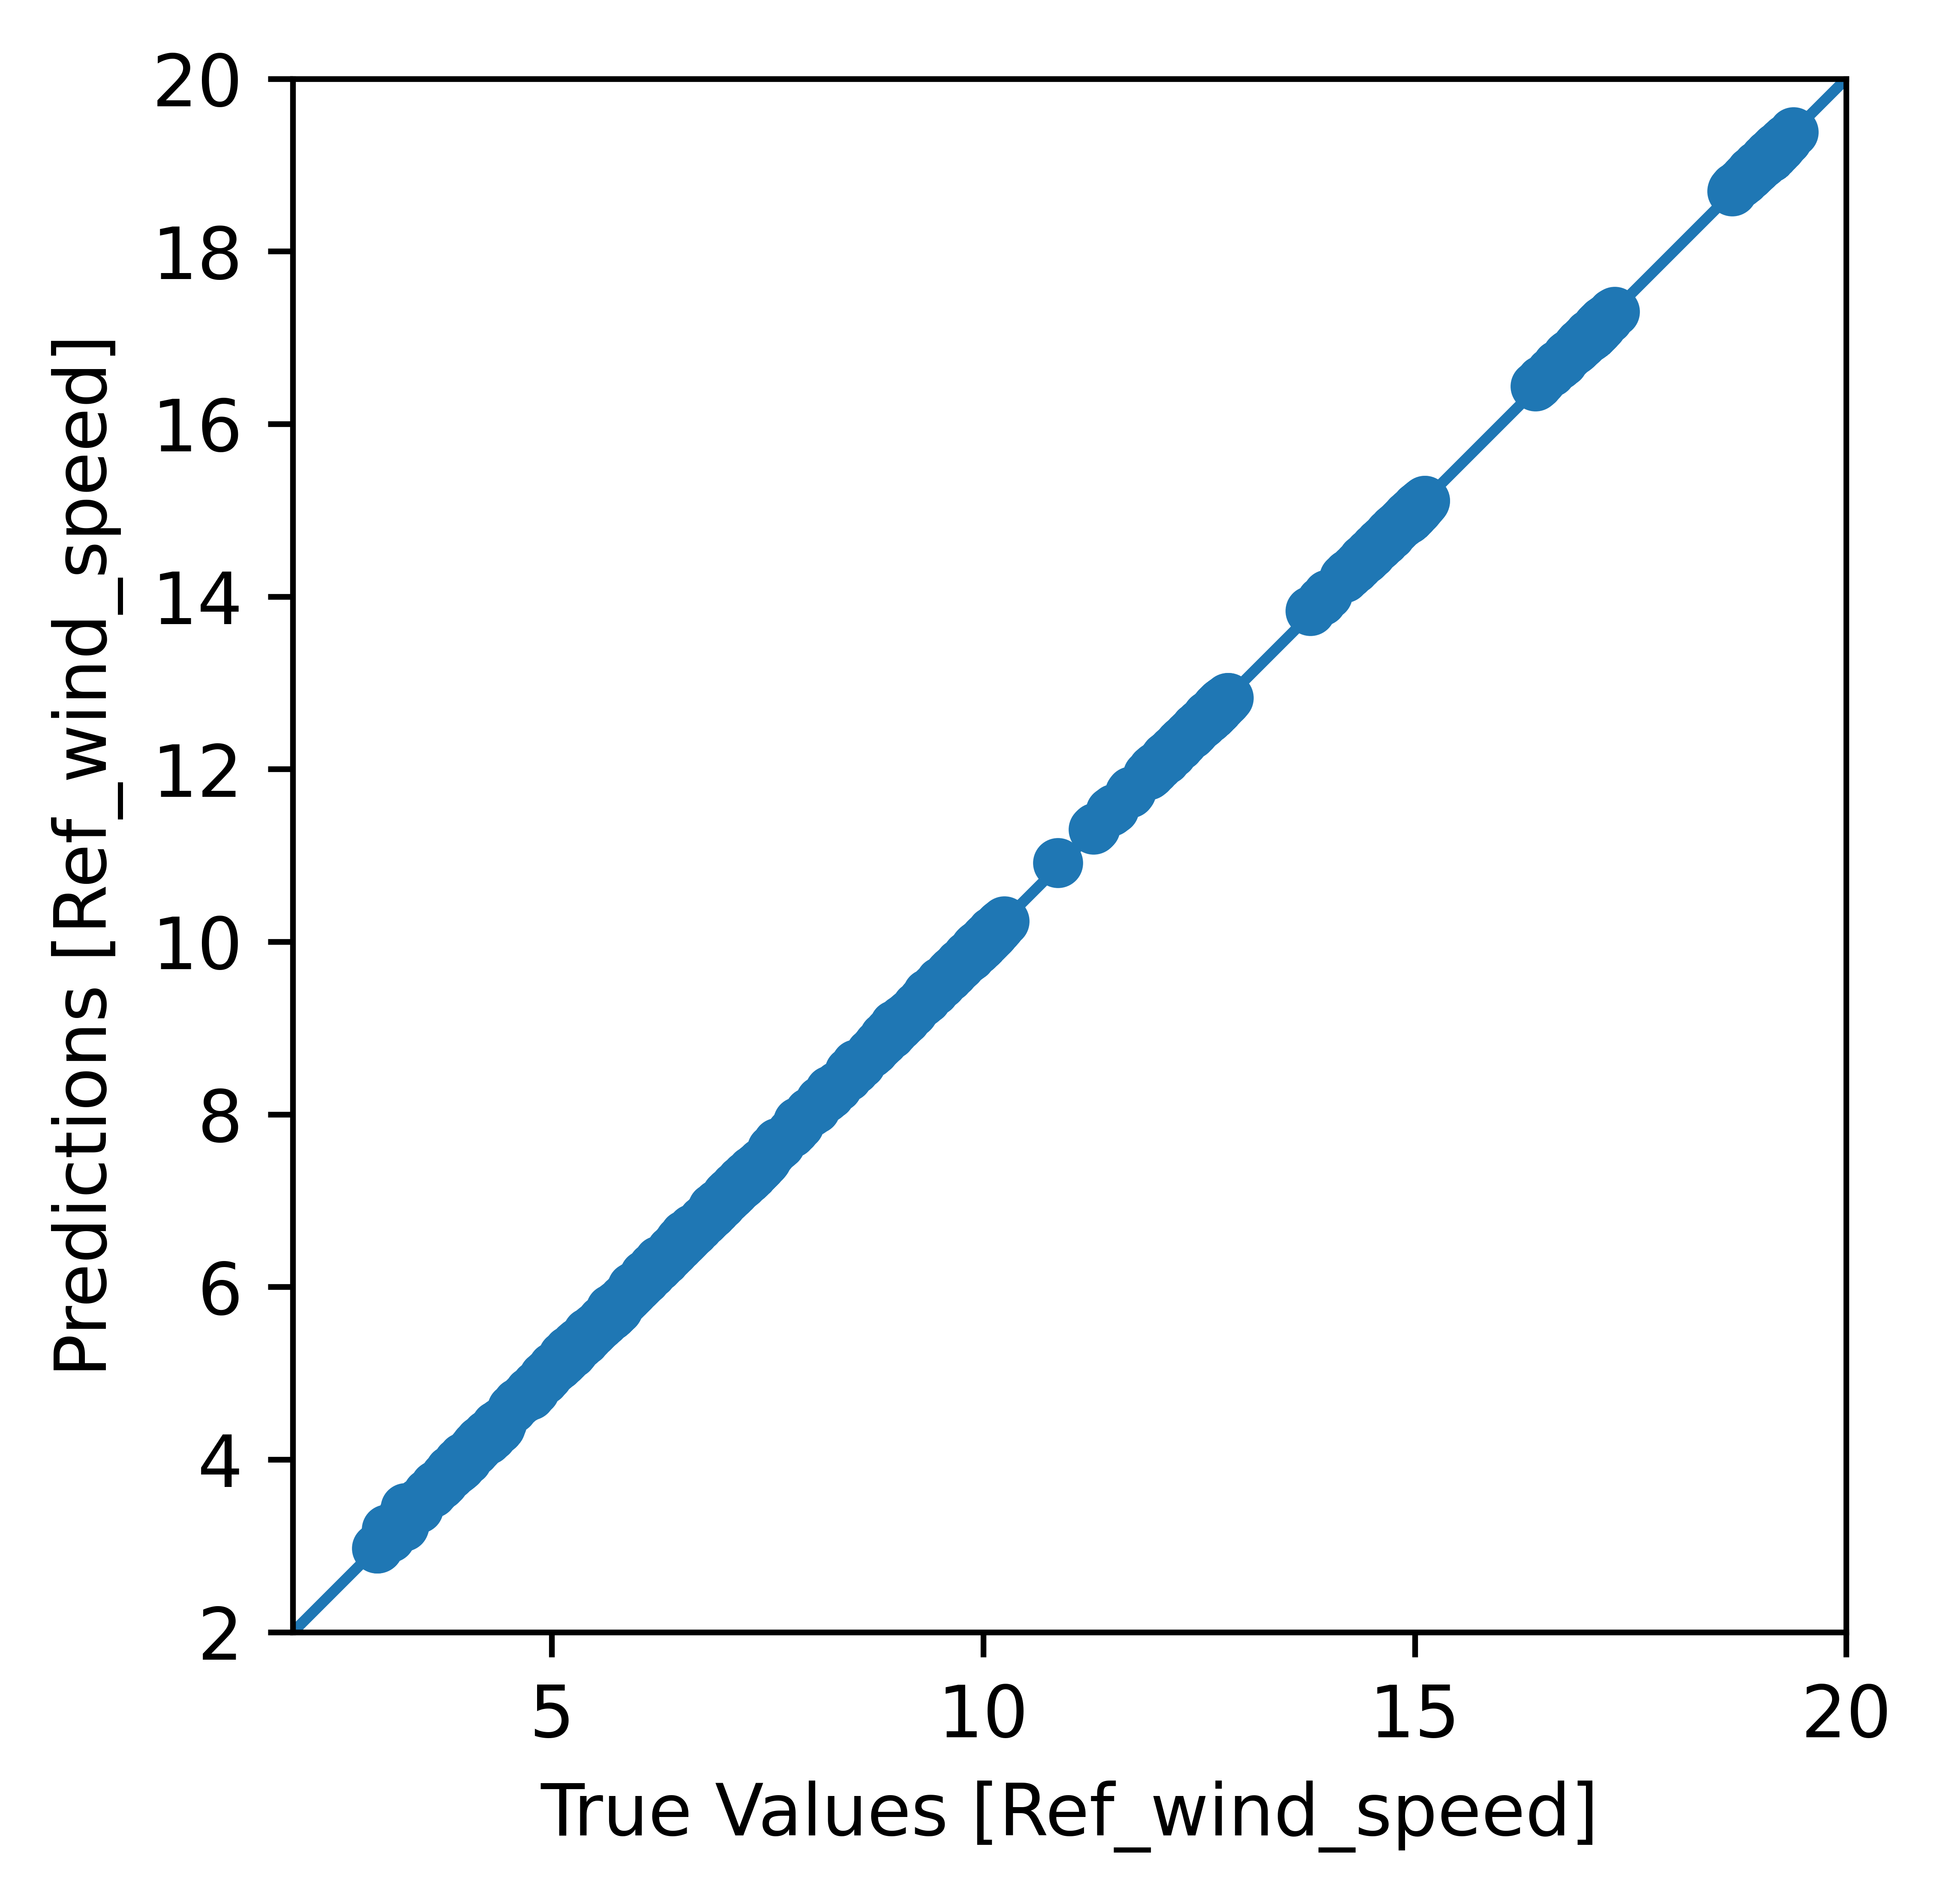

In [15]:
test_predictions = dnn_model.predict(test_features).flatten()
train_predictions = dnn_model.predict(train_features).flatten()
all_predictions = dnn_model.predict(all_features).flatten()
#test_predictions_0 = dnn_model.predict(test_features["Fingerprint(G2)"]==0).flatten()
#train_predictions_0 = dnn_model.predict(train_features["Fingerprint(G2)"]==0).flatten()
plt.figure(dpi=1200)
a = plt.axes(aspect='equal')
#plt.scatter(test_labels, test_predictions)#,c=test_features["Fingerprint(G2)"])
#plt.scatter(train_labels, train_predictions)#,c=train_features["Fingerprint(G2)"])
plt.scatter(all_labels, all_predictions)
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
#cbar=plt.colorbar()
#cbar.set_label('Fingerprint(G2)')
lims = [2, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

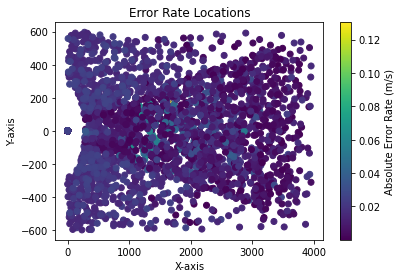

In [16]:
all_predictions = dnn_model.predict(all_features).flatten()
a = plt.axes
error_all=np.abs(all_predictions-all_labels)

plt.scatter(dataset_pos[:,0], dataset_pos[:,1],c=error_all)
#plt.scatter(train_features["Fingerprint(G2)"], train_features["Fingerprint(G4)"],c=train_labels)
#plt.scatter(train_labels, train_predictions)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Error Rate Locations')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

In [17]:
arg=np.argsort(error_all)
error_all[arg]

1970    9.578662e-07
286     2.765615e-05
2399    4.196526e-05
1324    5.912566e-05
3013    6.011818e-05
            ...     
2075    6.792116e-02
865     7.218504e-02
166     7.541799e-02
221     1.023638e-01
580     1.303616e-01
Name: 16, Length: 3840, dtype: float64

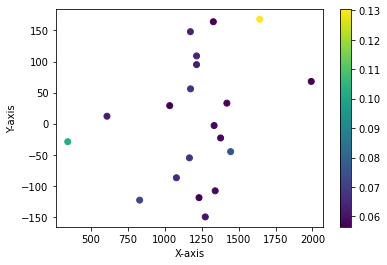

In [18]:
all_predictions = dnn_model.predict(all_features).flatten()
a = plt.axes
error_all=np.abs(all_predictions-all_labels)

plt.scatter(dataset_pos[arg[-20:],0], dataset_pos[arg[-20:],1],c=error_all[arg[-20:]])
#plt.scatter(train_features["Fingerprint(G2)"], train_features["Fingerprint(G4)"],c=train_labels)
#plt.scatter(train_labels, train_predictions)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar()

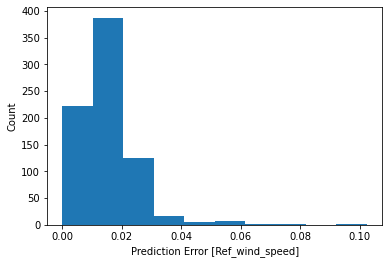

In [19]:
error_test = np.abs(test_predictions - test_labels)
plt.hist(error_test, bins=10)
plt.xlabel('Prediction Error [Ref_wind_speed]')
_ = plt.ylabel('Count')

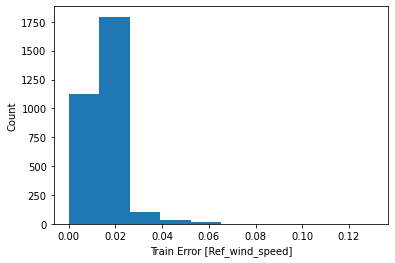

In [20]:
error_train = np.abs(train_predictions - train_labels)
plt.hist(error_train, bins=10)
plt.xlabel('Train Error [Ref_wind_speed]')
_ = plt.ylabel('Count')

In [21]:
print("Max test error:",np.max(error_test))
print("Mean test error:",np.mean(error_test))

Max test error: 0.10236382099426278
Mean test error: 0.015426071836867344


In [22]:
print("Max all error:",np.max(error_all))
print("Mean all error:",np.mean(error_all))

Max all error: 0.13036155792907733
Mean all error: 0.014885869509037012


In [23]:
print("Max train error:",np.max(error_train))
print("Mean train error:",np.mean(error_train))

Max train error: 0.13036155792907733
Mean train error: 0.01475082420457402


In [24]:
dnn_model.save('dnn_model')

2023-07-26 13:37:26.573864: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: dnn_model/assets


In [25]:
print(min(error),max(error))

NameError: name 'error' is not defined

In [ ]:
import matplotlib.cm as cm
plt.scatter(dataset['Fingerprint(G4)'],dataset['Fingerprint(G2)'], c=dataset['Ref_Wind_Speed'], s=10, cmap=cm.bwr)
cbar= plt.colorbar()
plt.xlabel('Fingerprint(G4)')
plt.ylabel('Fingerprint(G2)')
plt.show()

In [ ]:
# dnn_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
# import numpy
# from mayavi.mlab import *

# def test_points3d():


#     x = all_features["Fingerprint(G2)"]
#     y = all_features["Fingerprint(G4)"]
#     z = all_features["Fingerprint(G6)"]
#     s = error_all
#     colorbar(orientation='vertical')
#     xlabel('Fingerprint(G2)')
#     ylabel('Fingerprint(G4)')
#     zlabel('Fingerprint(G6)')
#     return points3d(x, y, z, s, colormap="blue-red", scale_factor=0.05)
# test_points3d()
# #colorbar(object=all_labels, title="Points in Mayavi")
# #view()
# show()